In [1]:
import torch
torch.set_printoptions(threshold=torch.inf) # shows all the values when printing tensors

import os
import pandas as pd
import gc # built-ing memory clean-up
from torchvision.transforms import Compose
from typing import Optional
from PIL import Image

In [2]:
# Changes the current working directory so to mimic running from repo root.
# os.getcwd().rsplit("/", 1)[0]
os.chdir(os.getcwd().rsplit("/", 1)[0])
print(os.getcwd())

/Users/tonyavis/Main/AI_public_projects/object_detection/yolo_v1_taco


In [3]:
# reloads external functions when its code changes
%load_ext autoreload
%autoreload 1
# %aimport will only reload those files
%aimport yolov1.dataset 
%aimport utils.plot
# %aimport utils.bboxes

from yolov1.dataset import Dataset
# from utils.bboxes import get_bboxes
from utils.plot import plot_bboxes

In [4]:
from argparse import Namespace
import torch.optim

torch.manual_seed(1)


# <------------- Hyperparameters/Config ------------->
config = Namespace(
    DEVICE = torch.device("mps"), # apple silicon M series
    NUM_WORKERS = 2,
    PIN_MEMORY = True,
    
    EPOCHS = 50,
    LEARNING_RATE = 2e-5,
    BATCH_SIZE = 64,
    WEIGHT_DECAY = 0, #TODO plasplay with weight decay

    # load a model with weights that u have been trained to train it more
    CON_TRAIN = False, # continue to train a model
    LOAD_MODEL_FILE = "./checkpoints/Yolov1_facemask_objectDetection_epoch50_2025-04-09-18h_31m.pt",
    
    DATASET_DIR = "./data", # root path to the dataset dir
    IMAGE_SIZE = 448,

    C = 18, # how many classes in the dataset
    B = 2, # how many bounding boxes does the model perdict per cell
    S = 7, # split_size, how to split the image, 7x7=49 grid cells,
    IOU_THRESHOLD = 0.5, # the iou threshold when comparing bounding boxes for NMS
    MIN_THRESHOLD = 0.4, # the minimal confidence to keep a predicted bounding box
)

config.NUM_NODES_PER_CELL = config.C + 5 * config.B # The total number of nodes per cell, which would be the size ==> [*classes, pc_1, bbox1_x_y_w_h, pc_2, bbox2_x_y_w_h] = 28 nodes.
config.NUM_NODES_PER_IMG = config.S * config.S * (config.C + config.B * 5) # The total number of nodes that each image has. If S=7 C=18 B=2 ==> 7*7 * (18 + 2 * 5) = 1,372 | 28*49 = 1,372 | the *5 is for pc_score, x, y, w, h



In [6]:
import torchvision.transforms as T

# <------------- Transforms ------------->
class Compose(object):
    """Apply a sequence of transforms safely on (image, bboxes)."""
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img, bboxes)
        return img, bboxes

class Resize(object):
    """Resize the image. No change needed for bboxes since they are normalized (0-1)."""
    def __init__(self, size):
        self.size = size  # (width, height) like (448,448)

    def __call__(self, img, bboxes):
        img = T.Resize(self.size)(img)
        return img, bboxes  # bboxes stay the same

class ToTensor(object):
    """Convert image to Tensor. Leave bboxes as they are."""
    def __call__(self, img, bboxes):
        img = T.ToTensor()(img)  # Automatically normalize image between 0-1
        return img, bboxes

transforms = Compose([
    Resize((448, 448)),  # Resize image to 448x448
    ToTensor(),          # Convert image to tensor
])

d = Dataset(S=config.S, C=config.C, B=config.B, mode="test", dataset_path="./data", transforms=None)
img, label = d.__getitem__(18)
label.shape


CSV file already exists.


torch.Size([7, 7, 28])

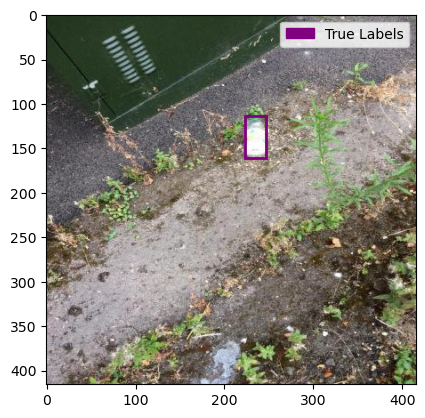

In [7]:
plot_bboxes(img, true_bboxes=label, config=config)

In [8]:
config.NUM_NODES_PER_CELL

28

In [9]:
config.NUM_NODES_PER_IMG

1372